Colabda Çalışacak Şekilde Düzenlenmiş Final Kod Yapısı

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
#import seaborn as sns
from tqdm import tqdm
import os
import cv2
import tensorflow as tf
import re
import pickle
from PIL import Image
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Conv2D, Concatenate, Flatten, Add, Dropout, GRU
import random
import datetime
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Tibbi_Goruntuleme_Proje/Final_Train_Data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Tibbi_Goruntuleme_Proje/Final_Test_Data.csv')
cv_data = pd.read_csv('/content/drive/MyDrive/Tibbi_Goruntuleme_Proje/Final_CV_Data.csv')

In [ ]:
X_train = train_data['Person_id']
X_test = test_data['Person_id']
X_cv = cv_data['Person_id']
y_train = train_data['Report']
y_test =  test_data['Report']
y_cv =  cv_data['Report']

In [ ]:
f = open('/content/drive/MyDrive/Tibbi_Goruntuleme_Proje/Image_features_ecoder_decoder.pickle','rb') # 300d glove vectors
Xnet_features = pickle.load(f)
f.close()

In [ ]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(y_train.values)
pading_size = 153   # Max length
vocab_size = len(tokenizer.word_index.keys()) + 1
f = open('/content/drive/MyDrive/GLOVE_VECTORS.pickle','rb') # 300d glove vectors
glove_vectors = pickle.load(f)
f.close()

In [ ]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.keys():
        vec = glove_vectors[word]
        embedding_matrix[i] = vec
    else:
        continue

In [ ]:
BATCH_SIZE = 12

In [ ]:
input1 = Input(shape=(2048,), name='Image_input')
dense1 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')(input1)

input2 = Input(shape=(153,), name='Text_Input')
embedding_layer = Embedding(input_dim = vocab_size, output_dim = 300, input_length=153, mask_zero=True, trainable=False,
                weights=[embedding_matrix], name="Embedding_layer")
emb = embedding_layer(input2)

LSTM1 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(emb)
#LSTM1_output = LSTM1(emb)

LSTM2 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")
LSTM2_output = LSTM2(LSTM1)

dropout1 = Dropout(0.5, name='dropout1')(LSTM2_output)

dec =  tf.keras.layers.Add()([dense1, dropout1])

fc1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed = 63), name='fc1')
fc1_output = fc1(dec)
dropout2 = Dropout(0.4, name='dropout2')(fc1_output)
output_layer = Dense(vocab_size, activation='softmax', name='Output_layer')
output = output_layer(dropout2)

encoder_decoder = Model(inputs = [input1, input2], outputs = output)
encoder_decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Text_Input          │ (None, 153)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding_layer     │ (None, 153, 300)  │    428,100 │ Text_Input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 153)       │          0 │ Text_Input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM1 (LSTM)        │ (None, 153, 256)  │    570,368 │ Embedding_layer[… │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM2 (LSTM)        │ (None, 256)       │    525,312 │ LSTM1[0][0],      │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_encoder       │ (None, 256)       │    524,544 │ Image_input[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 256)       │          0 │ LSTM2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense_encoder[0]… │
│                     │                   │            │ dropout1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc1 (Dense)         │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout2 (Dropout)  │ (None, 256)       │          0 │ fc1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_layer        │ (None, 1427)      │    366,739 │ dropout2[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,480,855 (9.46 MB)

 Trainable params: 2,052,755 (7.83 MB)

 Non-trainable params: 428,100 (1.63 MB)

In [ ]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='none')

def maskedLoss(y_true, y_pred):
    # Calculate loss per sample
    loss_ = loss_function(y_true, y_pred)  # (batch_size,)

    # Create mask: 1 if target exists, 0 if padded
    mask = tf.reduce_sum(y_true, axis=-1)  # (batch_size,)
    mask = tf.cast(mask != 0, loss_.dtype)

    # Apply mask
    loss_ = loss_ * mask

    # Return mean over non-masked
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [ ]:
encoder_decoder.compile(optimizer='adam', loss=maskedLoss)

In [ ]:
encoder_decoder.load_weights("/content/drive/MyDrive/Tibbi_Goruntuleme_Proje/encoder_decoder_epoch_100.weights.h5")

In [ ]:
# encoder
encoder_input = encoder_decoder.input[0]
encoder_output = encoder_decoder.get_layer('dense_encoder').output
encoder_model = Model(encoder_input, encoder_output)

# decoder#
text_input = encoder_decoder.input[1]
enc_output = Input(shape=(256,), name='Enc_Output')
text_output = encoder_decoder.get_layer('LSTM2').output
add1 = tf.keras.layers.Add()([text_output, enc_output])
fc_1 = fc1(add1)
decoder_output = output_layer(fc_1)

decoder_model = Model(inputs = [text_input, enc_output], outputs = decoder_output)

In [ ]:
def greedysearch(img):
    image = Xnet_features[img]
    input_ = 'startseq'
    image_features = encoder_model.predict(image)

    result = []
    for i in range(153):
        input_tok = [tokenizer.word_index[w] for w in input_.split()]
        input_padded = pad_sequences([input_tok], 153, padding='post')
        predictions = decoder_model.predict([input_padded, image_features])
        arg = np.argmax(predictions)
        if arg != 7:   # endseq
            result.append(tokenizer.index_word[arg])
            input_ = input_ + ' ' + tokenizer.index_word[arg]
        else:
            break
    rep = ' '.join(e for e in result)
    return rep

In [ ]:
def load_image(img_name):
    image = Image.open(img_name)
    X = np.asarray(image.convert("RGB"))
    X = np.asarray(X)
    X = preprocess_input(X)
    X = resize(X, (224,224,3))
    X = np.expand_dims(X, axis=0)
    X = np.asarray(X)
    return X

In [ ]:
import cv2
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator

def get_result(idx=0):
    pre_Report = greedysearch(cv_data['Person_id'][idx])
    print(cv_data['Person_id'][idx])
    translated_report = GoogleTranslator(source='en', target='tr').translate(pre_Report)
    print('------------------------------------------------------------------------------------------------------')
    print("Predicted Report : ", translated_report)
    print('------------------------------------------------------------------------------------------------------')
    print("Actual Report : ", cv_data['Report'][idx])

    base_path = "/content/drive/MyDrive/"
    # Image 1
    img1_path = base_path + cv_data['Image1'][idx]
    print(img1_path)
    img1 = cv2.imread(img1_path)
    if img1 is not None:
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    else:
        print(f"Image 1 not found at path: {img1_path}")

    # Image 2
    img2_path =base_path + cv_data['Image2'][idx]
    print(img2_path)
    img2 = cv2.imread(img2_path)
    if img2 is not None:
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    else:
        print(f"Image 2 not found at path: {img2_path}")

    # Görüntüleri matplotlib ile göster
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    if img1 is not None:
        axes[0].imshow(img1)
        axes[0].set_title("Image 1")
        axes[0].axis('off')

    if img2 is not None:
        axes[1].imshow(img2)
        axes[1].set_title("Image 2")
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
def get_result_by_person_id(person_id):
    # Hasta ID'sine göre idx'i bul
    idx = cv_data.index[cv_data['Person_id'] == person_id].tolist()
    if not idx:
        print(f"Hasta ID'si {person_id} bulunamadı!")
        return

    idx = idx[0]
    pre_Report = greedysearch(person_id)
    print("Hasta ID:", person_id)
    translated_report = GoogleTranslator(source='en', target='tr').translate(pre_Report)
    print('------------------------------------------------------------------------------------------------------')
    print("Predicted Report : ", translated_report)
    print('------------------------------------------------------------------------------------------------------')
    print("Actual Report : ", cv_data['Report'][idx])

    base_path = "/content/drive/MyDrive/"
    # Image 1
    img1_path = base_path + cv_data['Image1'][idx]
    print(img1_path)
    img1 = cv2.imread(img1_path)
    if img1 is not None:
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    else:
        print(f"Image 1 not found at path: {img1_path}")

    # Image 2
    img2_path = base_path + cv_data['Image2'][idx]
    print(img2_path)
    img2 = cv2.imread(img2_path)
    if img2 is not None:
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    else:
        print(f"Image 2 not found at path: {img2_path}")

    # Görüntüleri göster
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    if img1 is not None:
        axes[0].imshow(img1)
        axes[0].set_title("Image 1")
        axes[0].axis('off')
    if img2 is not None:
        axes[1].imshow(img2)
        axes[1].set_title("Image 2")
        axes[1].axis('off')
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

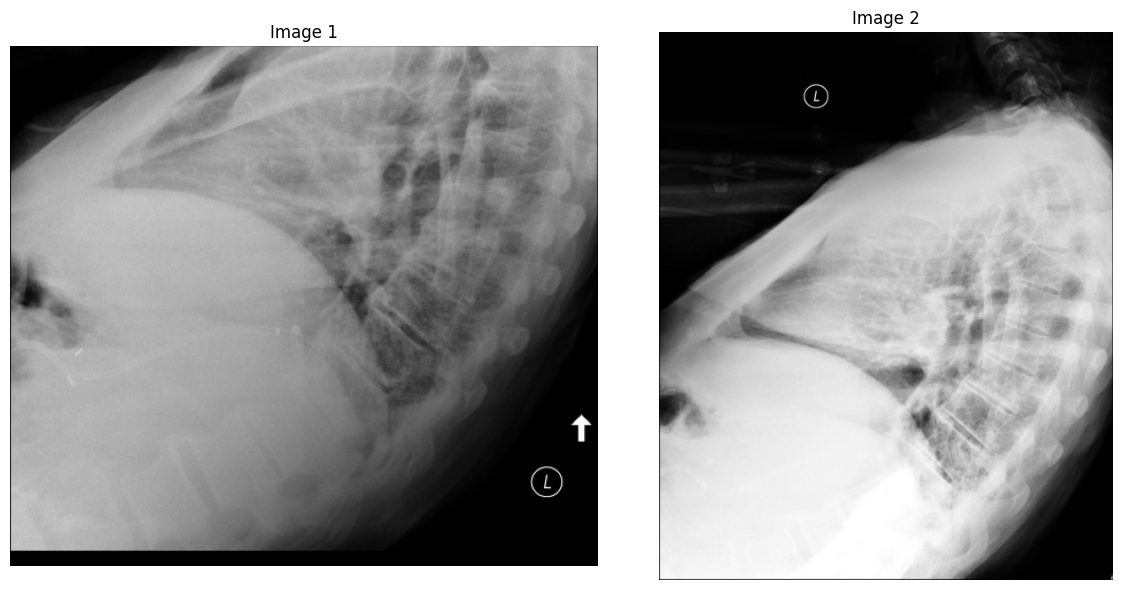

In [ ]:
get_result_by_person_id("NLMCXR_png/CXR372_IM-1858-0001_0")

In [ ]:
get_result_by_person_id("NLMCXR_png/CXR423_IM-2066-0001_2")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

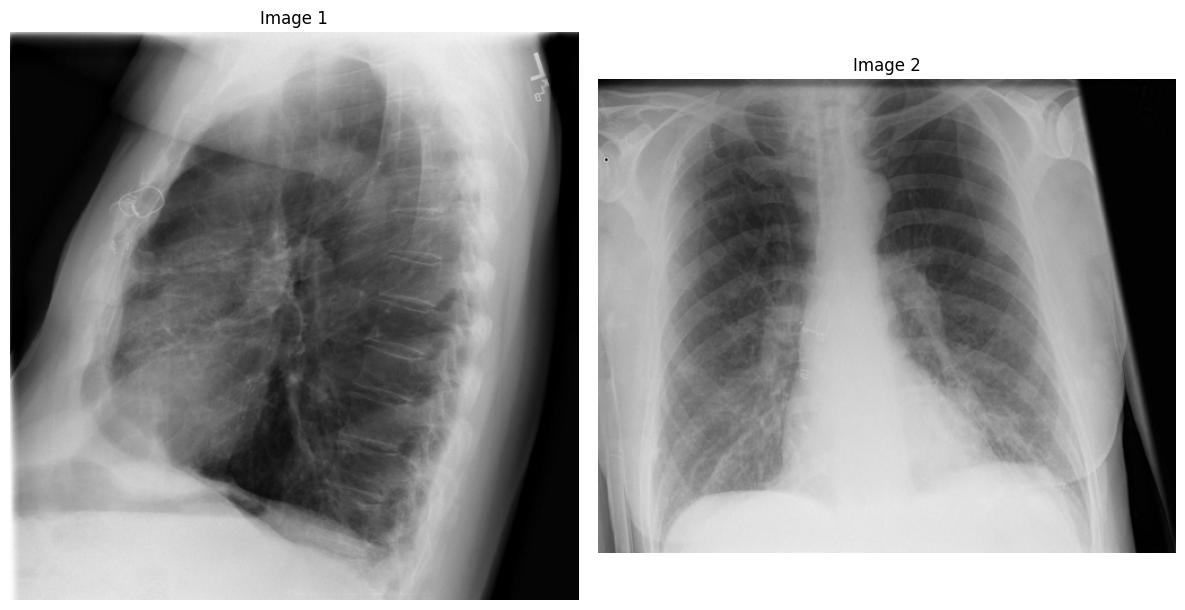

In [ ]:
get_result_by_person_id("NLMCXR_png/CXR573_IM-2171_2")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

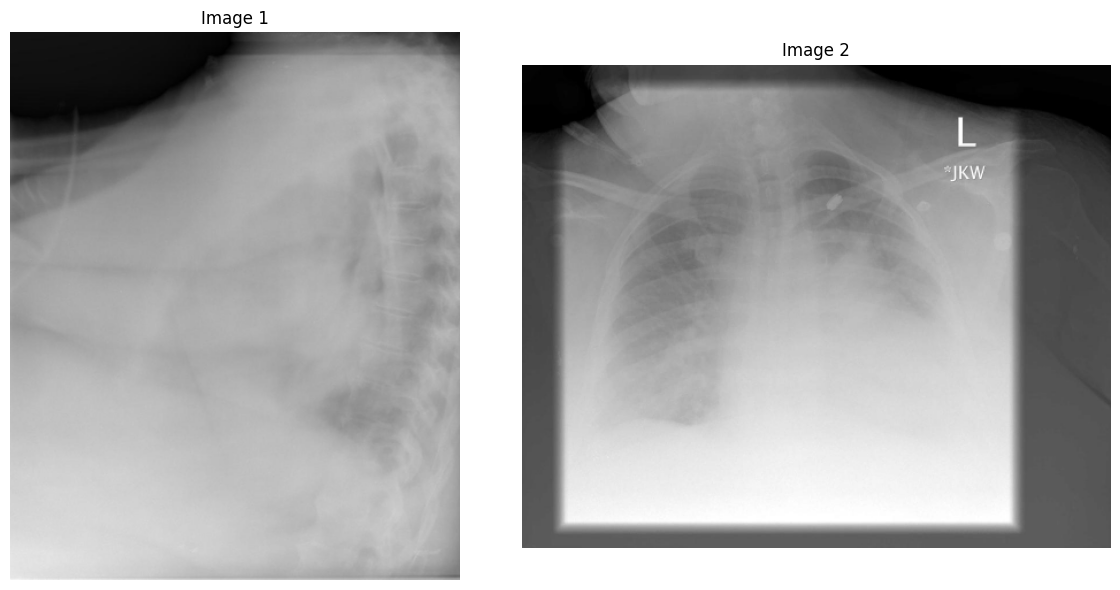

In [ ]:
get_result_by_person_id("NLMCXR_png/CXR3840_IM-1941_0")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

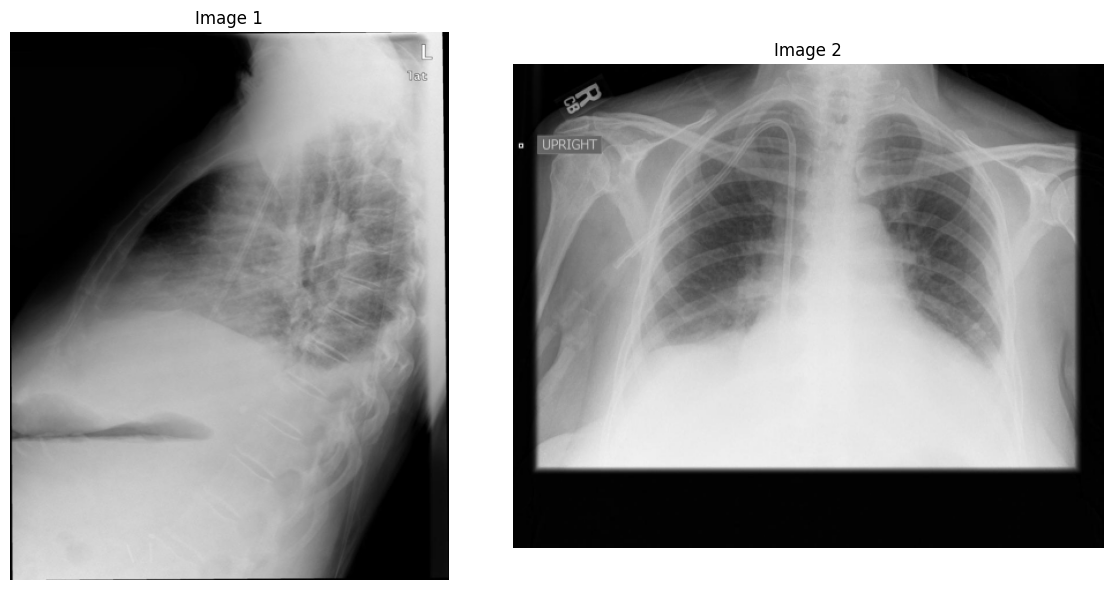

In [ ]:
get_result_by_person_id("NLMCXR_png/CXR379_IM-1903_0")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Hasta ID: NLMCXR_png/CXR3692_IM-1843_0
------------------------------------------------------------------------------------------------------
Predicted Report :  Kalp normal boyutu. mediastin. Akciğerler açıktır.
------------------------------------------------------------------------------------------------------
Actual Report :  startseq stable cardiomediastinal silhouette

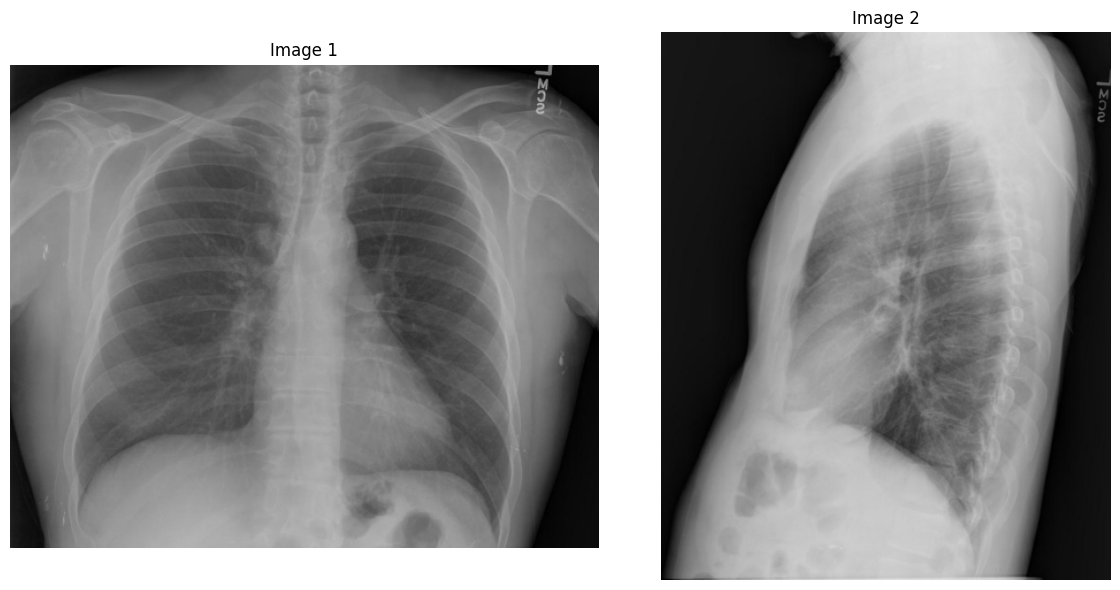

In [ ]:
get_result_by_person_id("NLMCXR_png/CXR3692_IM-1843_0")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Hasta ID: NLMCXR_png/CXR3714_IM-1856_0
------------------------------------------------------------------------------------------------------
Predicted Report :  Kalp normal boyutu. 

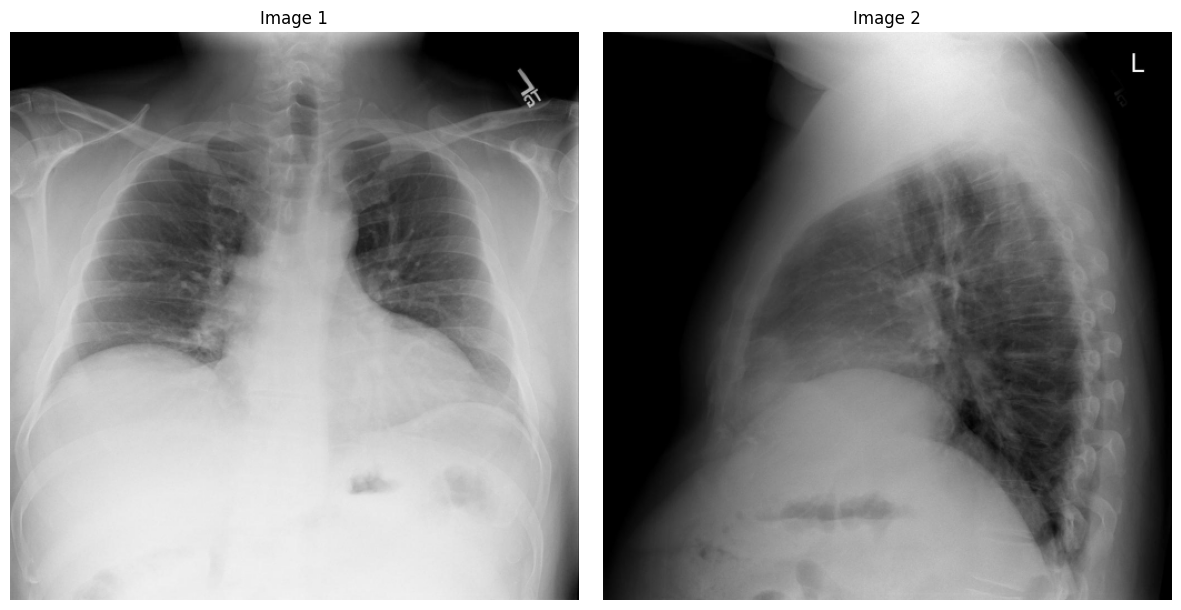

In [ ]:
get_result_by_person_id("NLMCXR_png/CXR3714_IM-1856_0")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

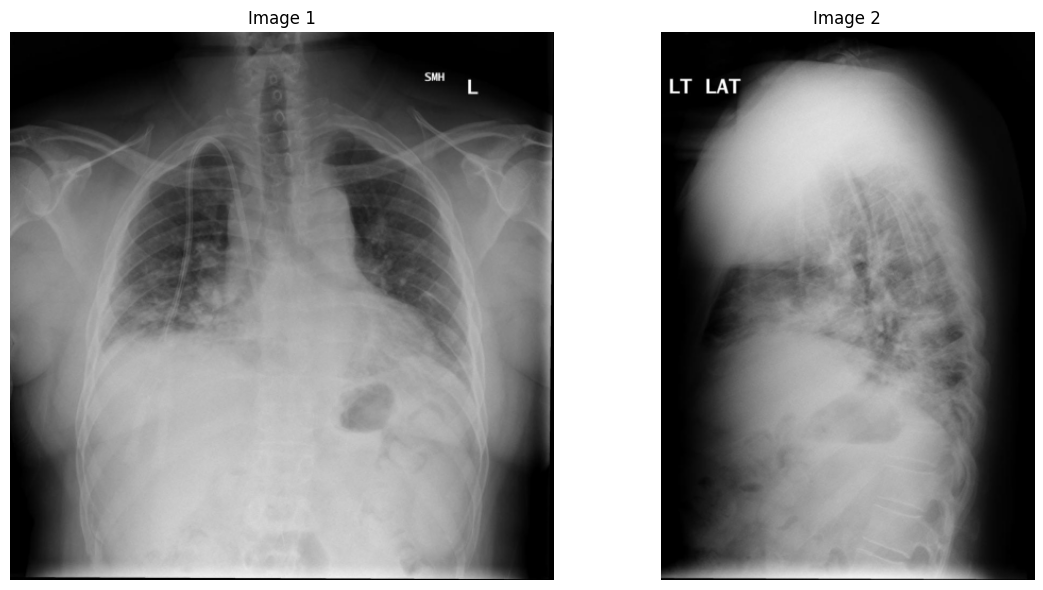

In [ ]:
get_result_by_person_id("NLMCXR_png/CXR601_IM-2192_0")